# Notebook 1: Web Scraping of Energy and Weather Data
Please see the `README.md` file to learn about this project.

In this first project notebook the raw energy data and weather data are requested from https://www.caiso.com/ and https://www.ncdc.noaa.gov/, respectively.


## 1.1 Web Scraping of Energy Data

The California ISO website reports the daily energy demand in megawatts in 5-minute increments. Historial data can be achieved dating back to April of 2018. The "demand" values being requested in this code, are the total system demand in California. Note that this is distinct from the "net demand" values that have subtracted the wind and solar energy. The net demand will not be analyzed in this project.

Note that a few of the dates, such as April 11, 2018, have incomplete data sets. The days with incomplete data will be cleaned later before modeling.

### Using Selenium to Automate Data Retrieval

The California ISO website allows the public to download energy demand CSV files for dates back through 2018. This process would take a very long time to do manually for each day though, so the Selenium 2 WebDriver API will be used to automate the process. The Chrome implementation is used here.

In [283]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys #The `Keys` class provides all the keys in the keyboard.

Start Chromedriver

In [284]:
#Create an instance of the Chrome WebDriver
driver = webdriver.Chrome('C:\\Users\\18053\\Desktop\\chromedriver')

#Driver.get to navigate to a given page
driver.get("http://www.caiso.com/TodaysOutlook/Pages/default.aspx")

C:\Users\18053\AppData\Local\Temp\ipykernel_24524\722848634.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('C:\\Users\\18053\\Desktop\\chromedriver')


In [285]:
#imports
import pandas as pd
import time
import datetime
import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

Set up date range to scrape from

In [286]:
start_dt = datetime.datetime(2018,4,10) #Earliest date available on the website

end_dt = datetime.datetime(2022,5,19) #Yesterday


Create a list of the dates in the format of MM/DD/YYYY

In [287]:
dates = []
for dt in pd.date_range(start_dt, end_dt):
    dates.append(dt.strftime("%m/%d/%Y"))

Print the dates to make sure the for loop worked correctly. Printing them using `PrettyPrinter`

In [288]:
pp = pprint.PrettyPrinter(indent=4,compact=True)
pp.pprint(dates)

[   '04/10/2018', '04/11/2018', '04/12/2018', '04/13/2018', '04/14/2018',
    '04/15/2018', '04/16/2018', '04/17/2018', '04/18/2018', '04/19/2018',
    '04/20/2018', '04/21/2018', '04/22/2018', '04/23/2018', '04/24/2018',
    '04/25/2018', '04/26/2018', '04/27/2018', '04/28/2018', '04/29/2018',
    '04/30/2018', '05/01/2018', '05/02/2018', '05/03/2018', '05/04/2018',
    '05/05/2018', '05/06/2018', '05/07/2018', '05/08/2018', '05/09/2018',
    '05/10/2018', '05/11/2018', '05/12/2018', '05/13/2018', '05/14/2018',
    '05/15/2018', '05/16/2018', '05/17/2018', '05/18/2018', '05/19/2018',
    '05/20/2018', '05/21/2018', '05/22/2018', '05/23/2018', '05/24/2018',
    '05/25/2018', '05/26/2018', '05/27/2018', '05/28/2018', '05/29/2018',
    '05/30/2018', '05/31/2018', '06/01/2018', '06/02/2018', '06/03/2018',
    '06/04/2018', '06/05/2018', '06/06/2018', '06/07/2018', '06/08/2018',
    '06/09/2018', '06/10/2018', '06/11/2018', '06/12/2018', '06/13/2018',
    '06/14/2018', '06/15/2018', '06/16

Define a function to select a given date on the website

In [289]:
def select_date(date,calendar_class):
    """
    input date in 'MM/DD/YYYY' form, and calendar_class as 'demand-date'
    
    """
    
    inputElement = driver.find_element(by=By.CLASS_NAME, value=calendar_class) #The HTML source code shows the calendar_class is what we need to access to select a date
    inputElement.clear()
    inputElement.send_keys(date)
    inputElement.send_keys(Keys.ENTER)

In [290]:
def download_file(button_id, hidden_button_id = ('','')):
    """Expecting the following:
    button_id: downloadDemandCSV, downloadNetDemandCSV 
    Hidden_button_id: (dropdownMenu1,0), (dropdownMenu1,2)
    button_id: actual download button, hidden button is the one hiding it."""
    
    if hidden_button_id[0] !='':
        if hidden_button_id[1]!='':
            inputElement = driver.find_elements(by=By.ID, value=hidden_button_id[0])[hidden_button_id[1]]
            inputElement.send_keys(Keys.ENTER)
        else:
            inputElement = driver.find_elements(by=By.ID, value=hidden_button_id[0])
            inputElement.send_keys(Keys.ENTER)
            
    wait = WebDriverWait(driver, 20)
    downloadButton= wait.until(EC.element_to_be_clickable((By.ID,button_id)))
    downloadButton.click()

In [291]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + datetime.timedelta(n)

Add a status bar for tracking for loop progress

In [292]:
import tqdm

In [293]:
for dt in tqdm.tqdm(dates):
    select_date(dt,'demand-date')
    download_file('downloadDemandCSV',('dropdownMenu1',0))

100%|██████████| 1501/1501 [11:05<00:00,  2.26it/s]


In [294]:
driver.close()

At this point the files were manually moved from the downloads folder to a new directory where they could readily be compiled into a single dataframe.

## 1.2 Compiling Raw Energy Demand Data

Examining format of a single day energy demand CSV file

In [295]:
df = pd.read_csv('C:\\Users\\18053\\Desktop\\Portfolio Projects\\Weather and Energy\\Energy Demand Data2\\CAISO-demand-20210827.csv')

In [296]:
df.head()

,Demand 08/27/2021,00:00,00:05,00:10,00:15,00:20,00:25,00:30,00:35,00:40,...,23:15,23:20,23:25,23:30,23:35,23:40,23:45,23:50,23:55,00:00.1
0,Day-ahead forecast,29164,27365,27365,27365,27365,27365,27365,27365,27365,...,30257,30257,30257,30257,30257,30257,30257,30257,30257,30257.0
1,Hour-ahead forecast,27593,27191,27191,27191,26760,26760,26760,26263,26263,...,30627,29995,29995,29995,29291,29291,29291,28743,28743,28743.0
2,Demand,27545,27444,27375,27237,27085,26900,26769,26583,26454,...,30700,30392,30163,29956,29763,29560,29384,29173,28959,NaN


The energy demand is reported in 5 minute increments in the third row of the dataframe. The first two rows are forecasted demand. For now only the true demand values are of interest, but the forecasted demand may be worth examining later as a comparison to the model that is developed to predict energy demand.

In [297]:
#Calculating the daily energy demand by summing all the columns in the third row.
daily_energy_demand =df.iloc[2,1:].sum()

In [298]:
daily_energy_demand 

9087498

In [299]:
#grabbing the date from the dataframe
date = df.columns[0][-10:]

In [300]:
date

'08/27/2021'

Setting up a master dataframe where all the days will have their daily energy demand values

In [301]:
masterdf= pd.DataFrame(columns = ['Date', 'Daily Energy Demand'])

In [302]:
masterdf

,Date,Daily Energy Demand


Checking to see if the date and energy demand values are being correctly sliced from the original dataframe

In [303]:
masterdf.loc[len(masterdf.index)] = [date,daily_energy_demand] 

In [304]:
masterdf

,Date,Daily Energy Demand
0,08/27/2021,9087498


Performing above steps for all 1501 energy demand files

In [305]:
import glob

In [306]:
path = 'C:\\Users\\18053\\Desktop\\Portfolio Projects\\Weather and Energy\\Energy Demand Data2' #Set search path and glob for files
files = glob.glob(path + '/*.csv') #Look for csv files in the input directory

In [307]:
masterdf= pd.DataFrame(columns = ['Date', 'Daily Energy Demand'])
for f in tqdm.tqdm(files):
   
    #same steps as was performed for 08/27/2021
    temp_df = pd.read_csv(f)
    daily_energy_demand =temp_df.iloc[2,1:].sum()
    date = temp_df.columns[0][-10:]
    masterdf.loc[len(masterdf.index)] = [date,daily_energy_demand] 



100%|██████████| 1501/1501 [00:18<00:00, 79.63it/s] 


In [308]:
masterdf

,Date,Daily Energy Demand
0,04/10/2018,7183786.0
1,04/11/2018,1961585.0
2,04/12/2018,6670701.0
3,04/13/2018,6643068.0
4,04/14/2018,6183992.0
...,...,...
1496,05/15/2022,6435770.0
1497,05/16/2022,6824397.0
1498,05/17/2022,6813256.0
1499,05/18/2022,7144889.0


In [309]:
energydf=masterdf.copy()

Looks good. The same number of rows in the dataframe as the number of files that were downloaded, so each date is occuring exactly once in the dataframe. As another check, the date range is what was specified in the initial scraping.

## 1.3 Web Scraping of Weather Data

NOAA's has an API that can be used to request weather data. To use this API a web services token was first requested. With access gained to NCDC CDO Web Services the base URL can be modified to request specific data sets.


To keep the scope manageable for this project, it was decided that only the most populated areas of California would have their weather as features.

| City | Approximate Population |
| --- | --- |
| Los Angeles | 4,000,000 | 
| San Diego | 1,400,000 | 
| San Jose | 1,000,000 | 
| San Francisco | 900,000 | 
| Fresno | 500,000 | 
| Sacramento | 500,000 | 

Since Los Angeles has such a large population, and is geographically diverse, it was decided that two weather stations from the Los Angeles area would be used as features, one from the LA inland region and one from the LA coastal region. The daily minimum and maximum temperatures were collected from seven regions.

An effort was made to find stations in each region with >99% data coverage in the date range of interest. Stations were found using https://www.ncdc.noaa.gov/cdo-web/datatools/findstation, California's id: FIPS:06 and the Daily Summaries datasetid, GHCND.






In [58]:
station_Locations = {'Los Angeles International Airport': 'GHCND:USW00023174', 'San Diego Airport':'GHCND:USW00023188',
                     'San Francisco Downtown': 'GHCND:USW00023272', 'FRESNO YOSEMITE INTERNATIONAL': 'GHCND:USW00093193', 'SACRAMENTO METROPOLITAN AIRPORT': 'GHCND:USW00093225',
                    'San Jose': 'GHCND:USW00023293', 'Ontario Airport': 'GHCND:USW00003102'}

Use Python's requests librarty to request the data 

In [59]:
import requests
import json 
import numpy as np
from datetime import datetime

Request Web Serviced Token from: https://www.ncdc.noaa.gov/cdo-web/token

In [62]:
Token = ''

The API has a 1000 item maximum item limit per call so it will be called once per year in the date range of interest.

In [64]:
#Initialize empty lists
dates = []
max_temp_values = []
min_temp_values = []
stations = []

#Assign the station list to the values from the dictionary of stations of interest
station_list = station_Locations.values()


#Scraping data from station_locations in 2018-2022
for station_id in station_list:
    for year in range(2018, 2023):
        try:
            year = str(year)
            #Print progress
            print('Working on year {} for station {}.'.format(year, station_id))

            #Make the API call
            #Units=standard means temp will be reported in F
            #datatypeid=TMAX and TMIN
            r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMAX&datatypeid=TMIN&units=standard&limit=1000&stationid='+station_id+'&startdate='+year+'-01-01&enddate='+year+'-12-31', headers={'token':Token})
            # Using the JSON library to deserialize the text attribute of the r object
            d = json.loads(r.text)
            
            #Get all TMAX and TMIN items in the response 
            max_temps = [item for item in d['results'] if item['datatype']=='TMAX']
            min_temps = [item for item in d['results'] if item['datatype']=='TMIN']

            #Get the date field from all temp readings
            dates += [item['date'] for item in max_temps]
            
            #Get the actual values of the min and max temps 
            max_temp_values += [item['value'] for item in max_temps]
            min_temp_values += [item['value'] for item in min_temps]
            
            #Get the station field
            stations += [item['station'] for item in max_temps]
            
        except:
            pass



Working on year 2018 for station GHCND:USW00023174.
Working on year 2019 for station GHCND:USW00023174.
Working on year 2020 for station GHCND:USW00023174.
Working on year 2021 for station GHCND:USW00023174.
Working on year 2022 for station GHCND:USW00023174.
Working on year 2018 for station GHCND:USW00023188.
Working on year 2019 for station GHCND:USW00023188.
Working on year 2020 for station GHCND:USW00023188.
Working on year 2021 for station GHCND:USW00023188.
Working on year 2022 for station GHCND:USW00023188.
Working on year 2018 for station GHCND:USW00023272.
Working on year 2019 for station GHCND:USW00023272.
Working on year 2020 for station GHCND:USW00023272.
Working on year 2021 for station GHCND:USW00023272.
Working on year 2022 for station GHCND:USW00023272.
Working on year 2018 for station GHCND:USW00093193.
Working on year 2019 for station GHCND:USW00093193.
Working on year 2020 for station GHCND:USW00093193.
Working on year 2021 for station GHCND:USW00093193.
Working on y

The length of min_temp_values was != the length of the max_temp_values, so the script can be run again for the minimum values and collect those dates. First let's see how the max temp data are looking.

In [ ]:
weather_df = pd.DataFrame(columns=['Date', 'Max Temp', 'Station ID'])
weather_df['Date'] = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates]
weather_df['Max Temp'] = max_temp_values #in deg F
weather_df['Station ID'] = stations

#Creating a column of station location names. Since original dictionary had the location names as the keys, a new dict was created with the names as values so they could be mapped.
swapped_dict = dict([(value, key) for key, value in station_Locations.items()])
weather_df['Station Location'] = weather_df['Station ID'].map(swapped_dict)

In [72]:
weather_df.head(10)

,Date,Max Temp,Station ID,Station Location
0,2018-01-01,67.0,GHCND:USW00023174,Los Angeles International Airport
1,2018-01-02,76.0,GHCND:USW00023174,Los Angeles International Airport
2,2018-01-03,76.0,GHCND:USW00023174,Los Angeles International Airport
3,2018-01-04,74.0,GHCND:USW00023174,Los Angeles International Airport
4,2018-01-05,69.0,GHCND:USW00023174,Los Angeles International Airport
5,2018-01-06,64.0,GHCND:USW00023174,Los Angeles International Airport
6,2018-01-07,69.0,GHCND:USW00023174,Los Angeles International Airport
7,2018-01-08,67.0,GHCND:USW00023174,Los Angeles International Airport
8,2018-01-09,63.0,GHCND:USW00023174,Los Angeles International Airport
9,2018-01-10,64.0,GHCND:USW00023174,Los Angeles International Airport


In [69]:
weather_df['Station Location'].unique()

array(['Los Angeles International Airport', 'San Diego Airport',
       'San Francisco Downtown', 'FRESNO YOSEMITE INTERNATIONAL',
       'SACRAMENTO METROPOLITAN AIRPORT', 'San Jose', 'Ontario Airport'],
      dtype=object)

In [93]:
maxtempdf = weather_df.copy()

Looks good! All 7 station locations are included in the data and the maximum temperature was pulled from each station for each each day in 2018-2022.

In [73]:
#Perform data requests again but this time for minimum temperature values
dates = []
min_temp_values = []
stations = []

#Assign the station list to the values from the dictionary of stations of interest
station_list = station_Locations.values()


#Scraping data from station_locations in 2018-2022
for station_id in station_list:
    for year in range(2018, 2023):
        try:
            year = str(year)
            #print progress
            print('Working on year {} for station {}.'.format(year, station_id))

            #make the api call
            r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMIN&units=standard&limit=1000&stationid='+station_id+'&startdate='+year+'-01-01&enddate='+year+'-12-31', headers={'token':Token})
            # Using the JSON library to deserialize the text attribute of the r object
            d = json.loads(r.text)
            #get all TMIN items in the response 
            min_temps = [item for item in d['results'] if item['datatype']=='TMIN']

            #get the date field from all temp readings
            dates += [item['date'] for item in min_temps]
            
            #get the actual values of the min and max temps 
            min_temp_values += [item['value'] for item in min_temps]
            
            #get the station field
            stations += [item['station'] for item in min_temps]
            
        except:
            pass


Working on year 2018 for station GHCND:USW00023174.
Working on year 2019 for station GHCND:USW00023174.
Working on year 2020 for station GHCND:USW00023174.
Working on year 2021 for station GHCND:USW00023174.
Working on year 2022 for station GHCND:USW00023174.
Working on year 2018 for station GHCND:USW00023188.
Working on year 2019 for station GHCND:USW00023188.
Working on year 2020 for station GHCND:USW00023188.
Working on year 2021 for station GHCND:USW00023188.
Working on year 2022 for station GHCND:USW00023188.
Working on year 2018 for station GHCND:USW00023272.
Working on year 2019 for station GHCND:USW00023272.
Working on year 2020 for station GHCND:USW00023272.
Working on year 2021 for station GHCND:USW00023272.
Working on year 2022 for station GHCND:USW00023272.
Working on year 2018 for station GHCND:USW00093193.
Working on year 2019 for station GHCND:USW00093193.
Working on year 2020 for station GHCND:USW00093193.
Working on year 2021 for station GHCND:USW00093193.
Working on y

In [75]:
min_weather_df = pd.DataFrame(columns=['Date', 'Min Temp', 'Station ID'])
min_weather_df['Date'] = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates]
min_weather_df['Min Temp'] = min_temp_values
min_weather_df['Station ID'] = stations
min_weather_df['Station Location'] = min_weather_df['Station ID'].map(swapped_dict)

In [76]:
min_weather_df

,Date,Min Temp,Station ID,Station Location
0,2018-01-01,48.0,GHCND:USW00023174,Los Angeles International Airport
1,2018-01-02,54.0,GHCND:USW00023174,Los Angeles International Airport
2,2018-01-03,54.0,GHCND:USW00023174,Los Angeles International Airport
3,2018-01-04,55.0,GHCND:USW00023174,Los Angeles International Airport
4,2018-01-05,56.0,GHCND:USW00023174,Los Angeles International Airport
...,...,...,...,...
11159,2022-05-12,48.0,GHCND:USW00003102,Ontario Airport
11160,2022-05-13,55.0,GHCND:USW00003102,Ontario Airport
11161,2022-05-14,59.0,GHCND:USW00003102,Ontario Airport
11162,2022-05-15,58.0,GHCND:USW00003102,Ontario Airport


In [94]:
mintempdf= min_weather_df.copy()

Now time to compile the min and max temp dataframes into one. The date column is going to be transformed into a datetime object so that it can be used to merge on. 

In [95]:
alltempdata = pd.merge(maxtempdf, mintempdf, how = 'inner', on= ['Date', 'Station ID', 'Station Location'])
#inner merge to prevent null values

In [96]:
alltempdata 

,Date,Max Temp,Station ID,Station Location,Min Temp
0,2018-01-01,67.0,GHCND:USW00023174,Los Angeles International Airport,48.0
1,2018-01-02,76.0,GHCND:USW00023174,Los Angeles International Airport,54.0
2,2018-01-03,76.0,GHCND:USW00023174,Los Angeles International Airport,54.0
3,2018-01-04,74.0,GHCND:USW00023174,Los Angeles International Airport,55.0
4,2018-01-05,69.0,GHCND:USW00023174,Los Angeles International Airport,56.0
...,...,...,...,...,...
11159,2022-05-12,84.0,GHCND:USW00003102,Ontario Airport,48.0
11160,2022-05-13,93.0,GHCND:USW00003102,Ontario Airport,55.0
11161,2022-05-14,97.0,GHCND:USW00003102,Ontario Airport,59.0
11162,2022-05-15,89.0,GHCND:USW00003102,Ontario Airport,58.0


Now to merge with the energy dataframe. The date formats are not the same between the dataframes so that needs to be fixed so they can be joined along the date column.

In [310]:
energydf.head()

,Date,Daily Energy Demand
0,04/10/2018,7183786.0
1,04/11/2018,1961585.0
2,04/12/2018,6670701.0
3,04/13/2018,6643068.0
4,04/14/2018,6183992.0


In [311]:
alltempdata['Date'] = pd.to_datetime((maxtempdf['Date']))
energydf['Date'] = pd.to_datetime((energydf['Date']))

In [312]:
alltempdata['Date'].max()

Timestamp('2022-05-16 00:00:00')

In [313]:
alltempdata['Date']

0       2018-01-01
1       2018-01-02
2       2018-01-03
3       2018-01-04
4       2018-01-05
           ...    
11159   2022-05-10
11160   2022-05-11
11161   2022-05-12
11162   2022-05-13
11163   2022-05-14
Name: Date, Length: 11164, dtype: datetime64[ns]

Notice that the temperature data doesn't end on the final date (05/16/2022), perhaps some weather stations don't have information for all the dates. Let's check what dates don't have values from all 7 stations.

In [314]:
test_df = pd.DataFrame({'date': alltempdata['Date'].value_counts().index, 'value_counts': alltempdata['Date'].value_counts()})

In [315]:
test_df[test_df['value_counts']<=6]

,date,value_counts
2019-11-18,2019-11-18,6
2018-02-28,2018-02-28,6
2022-05-15,2022-05-15,6
2021-04-23,2021-04-23,6
2018-08-03,2018-08-03,6
2018-08-04,2018-08-04,6
2018-08-05,2018-08-05,6
2018-08-06,2018-08-06,6
2018-08-07,2018-08-07,6
2018-08-08,2018-08-08,6


Looks like there are a handful of dates with missing data from one station and 1 date with data missing from 3 stations. Something to keep in mind during data cleaning.

Check that the date format was correctly transformed in energydf

In [316]:
energydf['Date']

0      2018-04-10
1      2018-04-11
2      2018-04-12
3      2018-04-13
4      2018-04-14
          ...    
1496   2022-05-15
1497   2022-05-16
1498   2022-05-17
1499   2022-05-18
1500   2022-05-19
Name: Date, Length: 1501, dtype: datetime64[ns]

In [317]:
energydf['Date'].min()

Timestamp('2018-04-10 00:00:00')

In [318]:
df = pd.merge(energydf, alltempdata, how = 'inner', on= ['Date'])
#inner merge to only have dates where there is both energy and temperature data (04/10/2018 - 05/16/2022, 1498 days)

In [319]:
energydf.head(14)

,Date,Daily Energy Demand
0,2018-04-10,7183786.0
1,2018-04-11,1961585.0
2,2018-04-12,6670701.0
3,2018-04-13,6643068.0
4,2018-04-14,6183992.0
5,2018-04-15,5926078.0
6,2018-04-16,6619344.0
7,2018-04-17,6567013.0
8,2018-04-18,6739403.0
9,2018-04-19,6649368.0


In [320]:
df.head(14)

,Date,Daily Energy Demand,Max Temp,Station ID,Station Location,Min Temp
0,2018-04-10,7183786.0,79.0,GHCND:USW00023174,Los Angeles International Airport,60.0
1,2018-04-10,7183786.0,85.0,GHCND:USW00023188,San Diego Airport,60.0
2,2018-04-10,7183786.0,63.0,GHCND:USW00023272,San Francisco Downtown,52.0
3,2018-04-10,7183786.0,86.0,GHCND:USW00093193,FRESNO YOSEMITE INTERNATIONAL,59.0
4,2018-04-10,7183786.0,68.0,GHCND:USW00093225,SACRAMENTO METROPOLITAN AIRPORT,51.0
5,2018-04-10,7183786.0,69.0,GHCND:USW00023293,San Jose,52.0
6,2018-04-10,7183786.0,72.0,GHCND:USW00003102,Ontario Airport,51.0
7,2018-04-11,1961585.0,74.0,GHCND:USW00023174,Los Angeles International Airport,57.0
8,2018-04-11,1961585.0,73.0,GHCND:USW00023188,San Diego Airport,60.0
9,2018-04-11,1961585.0,60.0,GHCND:USW00023272,San Francisco Downtown,49.0


In [321]:
df.to_csv('df.csv')

Great! Now we have a master dataframe with all the temperature and energy data we want for our modeling. 

See Notebook 2 for exploratory data analysis and data cleaning.

In [177]:
import seaborn as sns

Text(0.5, 1.0, "Fig. 1.1: California's Daily Energy Demand (2018-2022)")

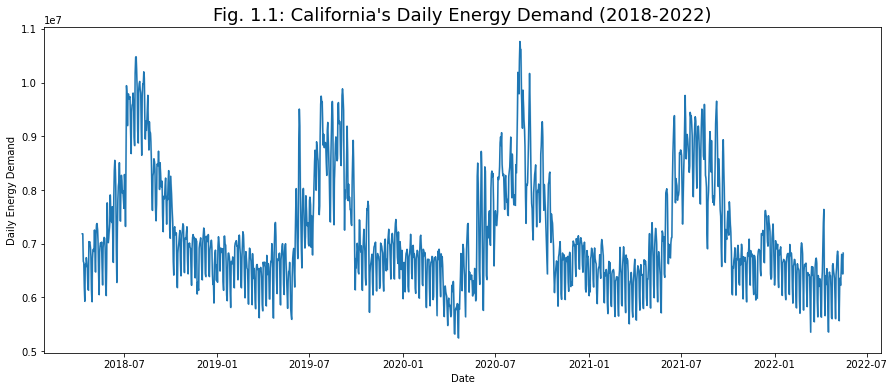

In [215]:
plt.figure(figsize=(15,6))
sns.lineplot( x ='Date', y= 'Daily Energy Demand', data = df) 
plt.title("Fig. 1.1: California's Daily Energy Demand (2018-2022)", fontsize=18)

Some general trends can be seen each year, there is an annual spike that begins around July, and energy demand in January is low, comparatively. 
This initial plot affirms that the seasons will be an important factor in determining energy demand. This project will consider the effect of seasonality using weather data.

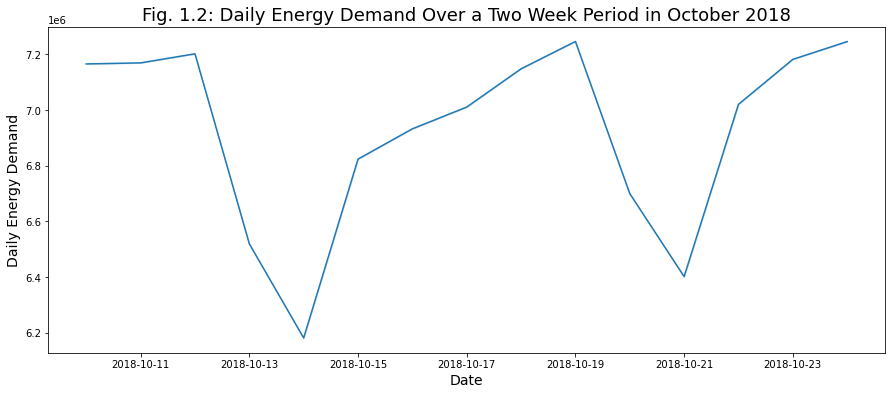

In [245]:
plt.figure(figsize=(15,6))
sns.lineplot( x ='Date', y= 'Daily Energy Demand', data = df.iloc[1280:1379]) #7*14 = 98 rows for a two week period
plt.title("Fig. 1.2: Daily Energy Demand Over a Two Week Period in October 2018", fontsize=18)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Looking at a random two week period, there are two dips, suggests the day of the week is potentially important. Let's create a feature for day of the week.

In [243]:
df['Day']= df['Date'].dt.day_name() #DateTime attribute

In [244]:
df.head(15)

,Date,Daily Energy Demand,Max Temp,Station ID,Station Location,Min Temp,Day
0,2018-04-10,7183786.0,79.0,GHCND:USW00023174,Los Angeles International Airport,60.0,Tuesday
1,2018-04-10,7183786.0,85.0,GHCND:USW00023188,San Diego Airport,60.0,Tuesday
2,2018-04-10,7183786.0,63.0,GHCND:USW00023272,San Francisco Downtown,52.0,Tuesday
3,2018-04-10,7183786.0,86.0,GHCND:USW00093193,FRESNO YOSEMITE INTERNATIONAL,59.0,Tuesday
4,2018-04-10,7183786.0,68.0,GHCND:USW00093225,SACRAMENTO METROPOLITAN AIRPORT,51.0,Tuesday
5,2018-04-10,7183786.0,69.0,GHCND:USW00023293,San Jose,52.0,Tuesday
6,2018-04-10,7183786.0,72.0,GHCND:USW00003102,Ontario Airport,51.0,Tuesday
7,2018-04-11,7183786.0,74.0,GHCND:USW00023174,Los Angeles International Airport,57.0,Wednesday
8,2018-04-11,7183786.0,73.0,GHCND:USW00023188,San Diego Airport,60.0,Wednesday
9,2018-04-11,7183786.0,60.0,GHCND:USW00023272,San Francisco Downtown,49.0,Wednesday


In [254]:
#specify the order of the week to set the x-axis order for plotting
dayorder= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

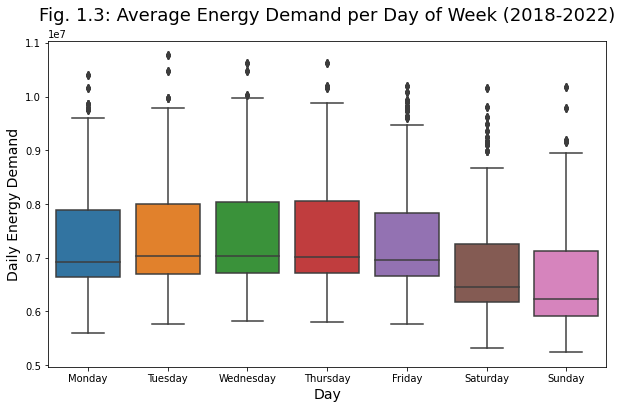

In [253]:
plt.figure(figsize=(10,6))
sns.boxplot(data = df, x= 'Day', y='Daily Energy Demand', order=dayorder)
plt.title("Fig. 1.3: Average Energy Demand per Day of Week (2018-2022)", fontsize=18, pad=20)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

 Looks like the day of the week will be an important feature when forecasting energy demand. Energy demand is fairly consistent Tuesdays-Thursdays, with a slight decrease on Fridays and Mondays, and then a more substantial decrease on Saturdays and Sundays. Perhaps holiday weekends play a role in affecting Monday and Friday demand.

In [255]:
df.groupby('Day')['Daily Energy Demand'].describe()

,count,mean,std,min,25%,50%,75%,max
Day,,,,,,,,
Friday,1496.0,7.323763e+06,1.005487e+06,5761548.0,6655160.0,6954462.5,7825330.0,10191567.0
Monday,1493.0,7.284840e+06,9.713531e+05,5588912.0,6638385.0,6917822.0,7881922.0,10409795.0
Saturday,1497.0,6.827500e+06,9.863419e+05,5324575.0,6164517.0,6451272.0,7259572.0,10157171.0
Sunday,1496.0,6.578258e+06,9.638517e+05,5242117.0,5916306.0,6228023.0,7130954.0,10171423.0
Thursday,1498.0,7.399167e+06,9.846564e+05,5803203.0,6721231.0,7011809.5,8051625.0,10617482.0
Tuesday,1496.0,7.387881e+06,9.863245e+05,5764182.0,6686602.0,7023464.0,7993980.0,10766451.0
Wednesday,1496.0,7.412304e+06,9.861986e+05,5820272.0,6713541.0,7030658.5,8029561.0,10617482.0


The statistics above are used to calculate the values in the boxplot. Note that the std is highest for Fridays, further suggesting holiday weekends may cause fluctuation in demand.

In [180]:
masterdf
#.sort_values().drop('Day').plot.bar()

,Date,Daily Energy Demand,Date_DateObj,Day,Month
0,08/17/2021,9140771,2021-08-17,Tuesday,August
1,08/18/2021,8273447,2021-08-18,Wednesday,August
2,08/19/2021,8273447,2021-08-19,Thursday,August
3,08/20/2021,8217546,2021-08-20,Friday,August
4,08/21/2021,8048332,2021-08-21,Saturday,August
...,...,...,...,...,...
255,04/29/2022,6350019,2022-04-29,Friday,April
256,04/30/2022,5941988,2022-04-30,Saturday,April
257,05/01/2022,5602366,2022-05-01,Sunday,May
258,05/02/2022,6351495,2022-05-02,Monday,May
